In [1]:
import csv
import re
import typing as t
from collections import defaultdict
from pathlib import Path

import nltk
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from nltk.corpus import stopwords, wordnet
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from tqdm import tqdm

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jovyan/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [3]:
DATA_DIR = Path("data/")

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {DEVICE.upper()} device")

Using CUDA device


In [4]:
def on_cuda(device: str) -> bool:
    return device == "cuda"


def common_train(
        model: nn.Module,
        loss_fn: nn.Module,
        optimizer: optim.Optimizer,
        train_dataloader: DataLoader,
        epochs: int,
        test_dataloader: DataLoader = None,
        lr_scheduler=None,
        verbose: int = 100,
        device: str = "cpu",
) -> t.List[float]:
    train_losses = []
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}\n" + "-" * 32)
        train_loss = train_loop(
            train_dataloader,
            model,
            loss_fn,
            optimizer,
            verbose=verbose,
            device=device,
        )
        train_losses.append(train_loss.item())
        if test_dataloader:
            loss, acc = test_loop(test_dataloader, model, loss_fn, device=device)
            if lr_scheduler:
                lr_scheduler.step(loss)
        torch.cuda.empty_cache()
    return train_losses


def train_loop(
        dataloader: DataLoader,
        model: nn.Module,
        loss_fn: nn.Module,
        optimizer: optim.Optimizer,
        verbose: int = 100,
        device: str = "cpu",
) -> torch.Tensor:
    model.train()

    size = len(dataloader.dataset)  # noqa
    num_batches = len(dataloader)
    avg_loss = 0

    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)

        pred = model(x)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()

        avg_loss += loss
        if batch % verbose == 0:
            print(f"loss: {loss:>7f}  [{batch * len(x):>5d}/{size:>5d}]")

        del x, y, pred, loss
        torch.cuda.empty_cache()

    return avg_loss / num_batches


@torch.no_grad()
def test_loop(
        dataloader: DataLoader,
        model: nn.Module,
        loss_fn: nn.Module,
        device: str = "cpu",
) -> t.Tuple[torch.Tensor, torch.Tensor]:
    model.eval()

    size = len(dataloader.dataset)  # noqa
    num_batches = len(dataloader)
    avg_loss, correct = 0, 0

    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        avg_loss += loss_fn(pred, y)
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()  # noqa

        del x, y, pred
        torch.cuda.empty_cache()

    avg_loss /= num_batches
    accuracy = correct / size
    print(f"Test Error: \n Accuracy: {accuracy:>4f}, Avg loss: {avg_loss:>8f} \n")

    return avg_loss, accuracy


def train_test_split(dataset: t.Union[Dataset, t.Sized], train_part: float) -> t.Tuple[Subset, Subset]:
    train_size = round(train_part * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, lengths=(train_size, test_size))
    return train_dataset, test_dataset


@torch.no_grad()
def get_y_test_y_pred(
        model: nn.Module,
        test_dataloader: DataLoader,
        device: str = "cpu",
) -> t.Tuple[torch.Tensor, torch.Tensor]:
    model.eval()

    y_test = []
    y_pred = []
    for x, y in test_dataloader:
        x, y = x.to(device), y.to(device)
        pred = model(x).argmax(1)
        y_test.append(y)
        y_pred.append(pred)

        del x
        torch.cuda.empty_cache()

    return torch.hstack(y_test).detach().cpu(), torch.hstack(y_pred).detach().cpu()

## 1. Классификация фамилий (RNN)

Датасет: https://disk.yandex.ru/d/frNchuaBQVLxyA?w=1

1.1 Используя класс `nn.RNNCell` (абстракцию для отдельного временного шага RNN), реализуйте простейшую рекуррентную сеть Элмана в виде класса `RNN`. Используя созданный класс `RNN`, решите задачу классификации фамилий. 


In [5]:
class RNN(nn.Module):

    def __init__(self, input_size: int, hidden_size: int):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.rnn_cell = nn.RNNCell(input_size, hidden_size)

    def forward(self, inputs: torch.Tensor, hx: torch.Tensor = None):
        batch_size, sequence_size, _ = inputs.size()
        inputs = inputs.permute(1, 0, 2)  # для nn.RNNCell batch_size должен быть на 2-ом месте

        if hx is None:
            # инициализация как в nn.RNN
            hx = torch.zeros(batch_size, self.hidden_size, dtype=inputs.dtype, device=inputs.device)
        else:
            # 1-ая размерность равная 1 для совместимости с nn.RNN
            hx = hx.squeeze(0)  # избавляемся от 1-ой размерности равной 1

        hidden = []
        for i in range(sequence_size):
            hx = self.rnn_cell(inputs[i], hx)
            hidden.append(hx)

        hidden = torch.stack(hidden)
        hx = hidden[-1].unsqueeze(0)
        # выход и скрытое состояние размерностей: (batch_size, ...), (1, batch_size, ...)
        return hidden.permute(1, 0, 2), hx

Проверка реализации RNN:

In [6]:
torch.manual_seed(0)

input_size, hidden_size = 4, 5
inputs = torch.randn(2, 3, input_size)
hx = torch.randn(1, 2, hidden_size)

torch.manual_seed(0)
my_rnn = RNN(input_size=input_size, hidden_size=hidden_size)

torch.manual_seed(0)
true_rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, batch_first=True)

In [7]:
my_rnn(inputs, hx)

(tensor([[[ 0.6515,  0.5430,  0.4023,  0.6325, -0.6068],
          [ 0.9149, -0.1088,  0.6385, -0.7387,  0.7532],
          [-0.6936,  0.5123, -0.2784, -0.5693, -0.0055]],
 
         [[ 0.1954,  0.6152,  0.2958, -0.8005,  0.8074],
          [-0.4577,  0.7566,  0.2972, -0.8834,  0.1265],
          [ 0.7166,  0.1516,  0.8047, -0.2007,  0.8192]]],
        grad_fn=<PermuteBackward>),
 tensor([[[-0.6936,  0.5123, -0.2784, -0.5693, -0.0055],
          [ 0.7166,  0.1516,  0.8047, -0.2007,  0.8192]]],
        grad_fn=<UnsqueezeBackward0>))

In [8]:
true_rnn(inputs, hx)

(tensor([[[ 0.6515,  0.5430,  0.4023,  0.6325, -0.6068],
          [ 0.9149, -0.1088,  0.6385, -0.7387,  0.7532],
          [-0.6936,  0.5123, -0.2784, -0.5693, -0.0055]],
 
         [[ 0.1954,  0.6152,  0.2958, -0.8005,  0.8074],
          [-0.4577,  0.7566,  0.2972, -0.8834,  0.1265],
          [ 0.7166,  0.1516,  0.8047, -0.2007,  0.8192]]],
        grad_fn=<TransposeBackward1>),
 tensor([[[-0.6936,  0.5123, -0.2784, -0.5693, -0.0055],
          [ 0.7166,  0.1516,  0.8047, -0.2007,  0.8192]]],
        grad_fn=<StackBackward>))

✅ 100% совпадение

In [9]:
class SurnamesRNNClassifier(nn.Module):

    def __init__(
            self,
            num_embeddings: int,
            embedding_dim: int,
            rnn_hidden_size: int,
            vector_size: int,
            num_classes: int,
    ):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=num_embeddings, embedding_dim=embedding_dim, padding_idx=0)
        self.rnn = RNN(input_size=embedding_dim, hidden_size=rnn_hidden_size)
        self.classifier = nn.Sequential(
            nn.Linear(rnn_hidden_size * vector_size, 256),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(256, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.embedding(x)
        # здесь позволим себе потерять скрытое состояние hx
        # в будущих моделях будем его сохранять
        x, hx = self.rnn(x)
        x = torch.flatten(x, 1)
        return self.classifier(x)

In [10]:
class SurnamesVocab:
    pad = "<PAD>"

    def __init__(self, surnames: t.List[str]):
        uniques = set()
        max_len = 0
        for w in map(str.lower, surnames):
            uniques.update(w)
            max_len = max(len(w), max_len)

        self.alphabet = [self.pad, *uniques]
        self.max_len = max_len
        self.ch2i = {ch: i for i, ch in enumerate(self.alphabet)}

    def __len__(self):
        return len(self.alphabet)

    def encode(self, word: str) -> torch.Tensor:
        indices = [self.ch2i[ch] for ch in word]
        indices += [self.ch2i[self.pad]] * (self.max_len - len(indices))
        return torch.tensor(indices, dtype=torch.long)

    def decode(self, indices: torch.Tensor) -> str:
        pad_indices = torch.nonzero(indices == self.ch2i[self.pad], as_tuple=True)[0]
        if len(pad_indices):
            indices = indices[:pad_indices[0]]
        return "".join(self.alphabet[i] for i in indices)


class SurnamesDataset(Dataset):
    df: pd.DataFrame
    surnames: t.List[str]
    vocab: SurnamesVocab
    labeler: LabelEncoder
    data: torch.Tensor
    targets: torch.Tensor

    def __init__(self, path: Path):
        self.df = pd.read_csv(path)

        self.surnames = self.df["surname"].tolist()
        self.vocab = SurnamesVocab(self.surnames)
        size = self.vocab.encode(self.surnames[0].lower()).size()
        data = torch.vstack([self.vocab.encode(w.lower()) for w in self.surnames])
        self.data = data.view(len(self.surnames), *size)

        self.labeler = LabelEncoder()
        targets = self.labeler.fit_transform(self.df["nationality"])
        self.targets = torch.tensor(targets, dtype=torch.long)

    def __len__(self):
        return self.data.size(0)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

    def encode(self, word: str) -> torch.Tensor:
        return self.vocab.encode(word)

    def decode(self, indices: torch.Tensor) -> str:
        return self.vocab.decode(indices)

In [11]:
surnames_dataset = SurnamesDataset(DATA_DIR / "surnames.csv")
len(surnames_dataset)

10980

In [12]:
torch.manual_seed(0)

train_surnames_dataset, test_surnames_dataset = train_test_split(surnames_dataset, train_part=0.8)
print(len(train_surnames_dataset), len(test_surnames_dataset))

8784 2196


### Handmade RNN

In [13]:
torch.manual_seed(0)

handmade_rnn_net = SurnamesRNNClassifier(
    num_embeddings=len(surnames_dataset.vocab),
    embedding_dim=128,
    rnn_hidden_size=64,
    vector_size=surnames_dataset.vocab.max_len,
    num_classes=len(surnames_dataset.labeler.classes_),
).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(handmade_rnn_net.parameters(), lr=0.0015)

train_dataloader = DataLoader(train_surnames_dataset, batch_size=128, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_surnames_dataset, batch_size=512)

In [14]:
%%time

_ = common_train(
    epochs=20,
    model=handmade_rnn_net,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    verbose=50,
    device=DEVICE,
)

Epoch 1
--------------------------------
loss: 2.874556  [    0/ 8784]
loss: 1.421411  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.641166, Avg loss: 1.217882 

Epoch 2
--------------------------------
loss: 1.065406  [    0/ 8784]
loss: 1.125816  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.706284, Avg loss: 1.034739 

Epoch 3
--------------------------------
loss: 0.922047  [    0/ 8784]
loss: 0.849748  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.723133, Avg loss: 0.945770 

Epoch 4
--------------------------------
loss: 0.826200  [    0/ 8784]
loss: 0.791709  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.735428, Avg loss: 0.909884 

Epoch 5
--------------------------------
loss: 0.740576  [    0/ 8784]
loss: 0.911624  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.741348, Avg loss: 0.874033 

Epoch 6
--------------------------------
loss: 0.717624  [    0/ 8784]
loss: 0.632623  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.749089, Avg loss: 0.864982 

Epoch 7
--------------------------------
loss: 0.517666  [    0/

In [15]:
y_test, y_pred = get_y_test_y_pred(handmade_rnn_net, test_dataloader, DEVICE)

print(metrics.classification_report(
    y_true=y_test,
    y_pred=y_pred,
    target_names=surnames_dataset.labeler.classes_,
    zero_division=True,
))

              precision    recall  f1-score   support

      Arabic       0.96      1.00      0.98       340
     Chinese       0.72      0.74      0.73        38
       Czech       0.60      0.35      0.44        96
       Dutch       0.76      0.43      0.55        51
     English       0.71      0.88      0.79       573
      French       0.13      0.05      0.07        39
      German       0.56      0.51      0.53       121
       Greek       0.70      0.56      0.62        34
       Irish       0.70      0.43      0.53        37
     Italian       0.72      0.78      0.75       128
    Japanese       0.87      0.88      0.88       156
      Korean       0.25      0.20      0.22        10
      Polish       0.61      0.42      0.50        26
  Portuguese       0.00      0.00      0.00         9
     Russian       0.87      0.84      0.85       458
    Scottish       0.00      0.00      0.00        17
     Spanish       0.43      0.48      0.45        50
  Vietnamese       0.38    

1.2 Замените модуль `RNN` из 1.1 на модули `nn.RNN`, `nn.LSTM` и `nn.GRU` (не забудьте указать аргумент `batch_first=True`). Сравните результаты работы.

In [16]:
class SurnamesAutobotRNNClassifier(nn.Module):

    def __init__(
            self,
            rnn_cls: t.Union[t.Type[nn.RNN], t.Type[nn.LSTM], t.Type[nn.GRU]],
            num_embeddings: int,
            embedding_dim: int,
            rnn_hidden_size: int,
            vector_size: int,
            num_classes: int,
    ):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=num_embeddings, embedding_dim=embedding_dim, padding_idx=0)
        self.hx, self.cx = None, None  # начальное скрытое состояние RNN
        self.rnn = rnn_cls(input_size=embedding_dim, hidden_size=rnn_hidden_size)  # подставляем любую реализацию RNN
        self.classifier = nn.Sequential(
            nn.Linear(rnn_hidden_size * vector_size, 256),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(256, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.embedding(x)

        if isinstance(self.rnn, (nn.RNN, nn.GRU)):
            x, hx = self.rnn(x, self.hx)
            self.hx = hx.detach()
        else:  # LSTM возвращает кортеж из 2-х тензоров в качестве скрытого состояния
            if self.hx is not None and self.cx is not None:
                hx_cx = (self.hx, self.cx)
            else:
                hx_cx = None
            x, (hx, cx) = self.rnn(x, hx_cx)
            self.cx = cx.detach()
            self.hx = hx.detach()

        x = torch.flatten(x, 1)
        return self.classifier(x)

### nn.RNN

In [17]:
torch.manual_seed(0)

rnn_net = SurnamesAutobotRNNClassifier(
    rnn_cls=nn.RNN,
    num_embeddings=len(surnames_dataset.vocab),
    embedding_dim=128,
    rnn_hidden_size=64,
    vector_size=surnames_dataset.vocab.max_len,
    num_classes=len(surnames_dataset.labeler.classes_),
).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(rnn_net.parameters(), lr=0.0015)

train_dataloader = DataLoader(train_surnames_dataset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_surnames_dataset, batch_size=512)

In [18]:
%%time

_ = common_train(
    epochs=20,
    model=rnn_net,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    verbose=50,
    device=DEVICE,
)

Epoch 1
--------------------------------
loss: 2.883942  [    0/ 8784]
loss: 1.602068  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.576503, Avg loss: 1.437185 

Epoch 2
--------------------------------
loss: 1.333282  [    0/ 8784]
loss: 1.292796  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.661202, Avg loss: 1.199116 

Epoch 3
--------------------------------
loss: 1.070057  [    0/ 8784]
loss: 0.994886  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.674863, Avg loss: 1.107447 

Epoch 4
--------------------------------
loss: 1.030502  [    0/ 8784]
loss: 0.881999  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.693078, Avg loss: 1.027522 

Epoch 5
--------------------------------
loss: 1.000975  [    0/ 8784]
loss: 0.978069  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.710383, Avg loss: 1.005455 

Epoch 6
--------------------------------
loss: 0.907455  [    0/ 8784]
loss: 0.865072  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.715847, Avg loss: 0.966902 

Epoch 7
--------------------------------
loss: 0.604049  [    0/

In [19]:
y_test, y_pred = get_y_test_y_pred(rnn_net, test_dataloader, DEVICE)

print(metrics.classification_report(
    y_true=y_test,
    y_pred=y_pred,
    target_names=surnames_dataset.labeler.classes_,
    zero_division=True,
))

              precision    recall  f1-score   support

      Arabic       0.97      1.00      0.98       340
     Chinese       0.74      0.66      0.69        38
       Czech       0.49      0.27      0.35        96
       Dutch       0.67      0.47      0.55        51
     English       0.70      0.83      0.76       573
      French       0.13      0.05      0.07        39
      German       0.58      0.52      0.55       121
       Greek       0.61      0.50      0.55        34
       Irish       0.46      0.16      0.24        37
     Italian       0.60      0.66      0.63       128
    Japanese       0.83      0.85      0.84       156
      Korean       0.33      0.40      0.36        10
      Polish       0.62      0.38      0.48        26
  Portuguese       0.33      0.11      0.17         9
     Russian       0.80      0.88      0.84       458
    Scottish       0.00      0.00      0.00        17
     Spanish       0.50      0.36      0.42        50
  Vietnamese       0.33    

### nn.LSTM

In [20]:
torch.manual_seed(0)

lstm_net = SurnamesAutobotRNNClassifier(
    rnn_cls=nn.LSTM,
    num_embeddings=len(surnames_dataset.vocab),
    embedding_dim=128,
    rnn_hidden_size=64,
    vector_size=surnames_dataset.vocab.max_len,
    num_classes=len(surnames_dataset.labeler.classes_),
).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm_net.parameters(), lr=0.0015)

train_dataloader = DataLoader(train_surnames_dataset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_surnames_dataset, batch_size=512)

In [21]:
%%time

_ = common_train(
    epochs=20,
    model=lstm_net,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    verbose=50,
    device=DEVICE,
)

Epoch 1
--------------------------------
loss: 2.884565  [    0/ 8784]
loss: 1.831156  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.546903, Avg loss: 1.560420 

Epoch 2
--------------------------------
loss: 1.449702  [    0/ 8784]
loss: 1.589251  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.628415, Avg loss: 1.303952 

Epoch 3
--------------------------------
loss: 1.277747  [    0/ 8784]
loss: 1.260169  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.669854, Avg loss: 1.165356 

Epoch 4
--------------------------------
loss: 1.056461  [    0/ 8784]
loss: 1.085960  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.676230, Avg loss: 1.091754 

Epoch 5
--------------------------------
loss: 1.029248  [    0/ 8784]
loss: 0.955076  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.692623, Avg loss: 1.033219 

Epoch 6
--------------------------------
loss: 1.032812  [    0/ 8784]
loss: 0.846041  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.709927, Avg loss: 0.988087 

Epoch 7
--------------------------------
loss: 0.890109  [    0/

In [22]:
y_test, y_pred = get_y_test_y_pred(lstm_net, test_dataloader, DEVICE)

print(metrics.classification_report(
    y_true=y_test,
    y_pred=y_pred,
    target_names=surnames_dataset.labeler.classes_,
    zero_division=True,
))

              precision    recall  f1-score   support

      Arabic       0.94      1.00      0.97       340
     Chinese       0.77      0.79      0.78        38
       Czech       0.63      0.28      0.39        96
       Dutch       0.78      0.41      0.54        51
     English       0.68      0.87      0.76       573
      French       0.00      0.00      0.00        39
      German       0.58      0.44      0.50       121
       Greek       0.62      0.53      0.57        34
       Irish       0.83      0.27      0.41        37
     Italian       0.58      0.72      0.64       128
    Japanese       0.86      0.84      0.85       156
      Korean       0.33      0.30      0.32        10
      Polish       0.62      0.38      0.48        26
  Portuguese       0.00      0.00      0.00         9
     Russian       0.84      0.85      0.84       458
    Scottish       0.00      0.00      0.00        17
     Spanish       0.38      0.36      0.37        50
  Vietnamese       0.67    

### nn.GRU

In [23]:
torch.manual_seed(0)

gru_net = SurnamesAutobotRNNClassifier(
    rnn_cls=nn.GRU,
    num_embeddings=len(surnames_dataset.vocab),
    embedding_dim=128,
    rnn_hidden_size=64,
    vector_size=surnames_dataset.vocab.max_len,
    num_classes=len(surnames_dataset.labeler.classes_),
).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(gru_net.parameters(), lr=0.0015)

train_dataloader = DataLoader(train_surnames_dataset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_surnames_dataset, batch_size=512)

In [24]:
%%time

_ = common_train(
    epochs=20,
    model=gru_net,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    verbose=50,
    device=DEVICE,
)

Epoch 1
--------------------------------
loss: 2.879841  [    0/ 8784]
loss: 1.722876  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.557832, Avg loss: 1.545358 

Epoch 2
--------------------------------
loss: 1.655988  [    0/ 8784]
loss: 1.203939  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.632969, Avg loss: 1.254734 

Epoch 3
--------------------------------
loss: 1.243177  [    0/ 8784]
loss: 1.277447  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.664390, Avg loss: 1.149105 

Epoch 4
--------------------------------
loss: 1.078428  [    0/ 8784]
loss: 1.050015  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.692623, Avg loss: 1.062530 

Epoch 5
--------------------------------
loss: 1.105967  [    0/ 8784]
loss: 0.912017  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.704463, Avg loss: 0.999653 

Epoch 6
--------------------------------
loss: 0.869840  [    0/ 8784]
loss: 0.698957  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.714481, Avg loss: 0.964454 

Epoch 7
--------------------------------
loss: 0.777239  [    0/

In [25]:
y_test, y_pred = get_y_test_y_pred(gru_net, test_dataloader, DEVICE)

print(metrics.classification_report(
    y_true=y_test,
    y_pred=y_pred,
    target_names=surnames_dataset.labeler.classes_,
    zero_division=True,
))

              precision    recall  f1-score   support

      Arabic       0.96      1.00      0.98       340
     Chinese       0.72      0.76      0.74        38
       Czech       0.57      0.24      0.34        96
       Dutch       0.71      0.43      0.54        51
     English       0.69      0.88      0.78       573
      French       0.14      0.08      0.10        39
      German       0.57      0.40      0.47       121
       Greek       0.71      0.44      0.55        34
       Irish       0.75      0.24      0.37        37
     Italian       0.65      0.73      0.69       128
    Japanese       0.81      0.86      0.83       156
      Korean       0.00      0.00      0.00        10
      Polish       0.50      0.35      0.41        26
  Portuguese       0.25      0.11      0.15         9
     Russian       0.82      0.87      0.84       458
    Scottish       0.00      0.00      0.00        17
     Spanish       0.53      0.36      0.43        50
  Vietnamese       0.25    

Интересно, что пользовательская реализация RNN, которая при проверки отработала число в число с nn.RNN, дала лучшую точность

1.3 Загрузите предобученные эмбеддинги (https://disk.yandex.ru/d/BHuT2tEXr_yBOQ?w=1) в модуль `nn.Embedding` и обучите модели из 1.2.

In [26]:
class SurnamesDecepticonRNNClassifier(nn.Module):

    def __init__(
            self,
            embedding: nn.Embedding,
            rnn_cls: t.Union[t.Type[nn.RNN], t.Type[nn.LSTM], t.Type[nn.GRU]],
            rnn_hidden_size: int,
            vector_size: int,
            num_classes: int,
    ):
        super().__init__()
        self.embedding = embedding
        self.hx, self.cx = None, None
        self.rnn = rnn_cls(input_size=self.embedding.embedding_dim, hidden_size=rnn_hidden_size)
        self.classifier = nn.Sequential(
            nn.Linear(rnn_hidden_size * vector_size, 256),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(256, num_classes),
        )

    def reset_rnn_state(self):
        self.hx, self.cx = None, None

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.embedding(x)

        if isinstance(self.rnn, (nn.RNN, nn.GRU)):
            x, hx = self.rnn(x, self.hx)
            self.hx = hx.detach()
        else:
            if self.hx is not None and self.cx is not None:
                hx_cx = (self.hx, self.cx)
            else:
                hx_cx = None
            x, (hx, cx) = self.rnn(x, hx_cx)
            self.hx = hx.detach()
            self.cx = cx.detach()

        x = torch.flatten(x, 1)
        return self.classifier(x)

In [27]:
torch.manual_seed(0)

embedding_weights = pd.read_csv(
    DATA_DIR / "glove.6B/glove.6B.50d.txt",
    sep=" ",
    quoting=csv.QUOTE_NONE,
    index_col=0,
    header=None,
)

# инициализация как в nn.Embedding
weights = torch.ones(len(surnames_dataset.vocab), embedding_weights.shape[1], dtype=torch.float32)
torch.nn.init.normal_(weights)

miss = 0  # счетчик отсутствующих токенов
for i, ch in enumerate(surnames_dataset.vocab.alphabet):
    try:
        weights[i] = torch.from_numpy(embedding_weights.loc[ch].to_numpy())
    except KeyError:
        miss += 1

embedding = nn.Embedding.from_pretrained(weights, padding_idx=0)
embedding, miss

(Embedding(56, 50, padding_idx=0), 5)

### nn.RNN

In [28]:
torch.manual_seed(0)

rnn_net = SurnamesDecepticonRNNClassifier(
    embedding=embedding,
    rnn_cls=nn.RNN,
    rnn_hidden_size=64,
    vector_size=surnames_dataset.vocab.max_len,
    num_classes=len(surnames_dataset.labeler.classes_),
).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(rnn_net.parameters(), lr=0.0015)

train_dataloader = DataLoader(train_surnames_dataset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_surnames_dataset, batch_size=512)

In [29]:
%%time

_ = common_train(
    epochs=20,
    model=rnn_net,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    verbose=50,
    device=DEVICE,
)

Epoch 1
--------------------------------
loss: 2.844056  [    0/ 8784]
loss: 1.963993  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.468579, Avg loss: 1.820995 

Epoch 2
--------------------------------
loss: 1.773461  [    0/ 8784]
loss: 1.701152  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.551002, Avg loss: 1.583422 

Epoch 3
--------------------------------
loss: 1.596159  [    0/ 8784]
loss: 1.530861  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.593352, Avg loss: 1.425762 

Epoch 4
--------------------------------
loss: 1.425993  [    0/ 8784]
loss: 1.283223  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.618852, Avg loss: 1.308009 

Epoch 5
--------------------------------
loss: 1.013008  [    0/ 8784]
loss: 1.279283  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.647996, Avg loss: 1.210004 

Epoch 6
--------------------------------
loss: 1.181927  [    0/ 8784]
loss: 1.356983  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.673042, Avg loss: 1.168989 

Epoch 7
--------------------------------
loss: 0.977154  [    0/

In [30]:
y_test, y_pred = get_y_test_y_pred(rnn_net, test_dataloader, DEVICE)

print(metrics.classification_report(
    y_true=y_test,
    y_pred=y_pred,
    target_names=surnames_dataset.labeler.classes_,
    zero_division=True,
))

              precision    recall  f1-score   support

      Arabic       0.94      1.00      0.97       340
     Chinese       0.71      0.95      0.81        38
       Czech       0.47      0.20      0.28        96
       Dutch       0.63      0.24      0.34        51
     English       0.64      0.90      0.75       573
      French       0.38      0.08      0.13        39
      German       0.56      0.31      0.40       121
       Greek       0.61      0.41      0.49        34
       Irish       0.78      0.19      0.30        37
     Italian       0.65      0.69      0.67       128
    Japanese       0.75      0.86      0.80       156
      Korean       0.33      0.10      0.15        10
      Polish       0.47      0.35      0.40        26
  Portuguese       0.50      0.11      0.18         9
     Russian       0.85      0.84      0.84       458
    Scottish       1.00      0.00      0.00        17
     Spanish       0.50      0.18      0.26        50
  Vietnamese       1.00    

### nn.LSTM

In [31]:
torch.manual_seed(0)

lstm_net = SurnamesDecepticonRNNClassifier(
    embedding=embedding,
    rnn_cls=nn.LSTM,
    rnn_hidden_size=64,
    vector_size=surnames_dataset.vocab.max_len,
    num_classes=len(surnames_dataset.labeler.classes_),
).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm_net.parameters(), lr=0.0015)

train_dataloader = DataLoader(train_surnames_dataset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_surnames_dataset, batch_size=512)

In [32]:
%%time

_ = common_train(
    epochs=20,
    model=lstm_net,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    verbose=50,
    device=DEVICE,
)

Epoch 1
--------------------------------
loss: 2.900342  [    0/ 8784]
loss: 2.213983  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.428051, Avg loss: 1.954197 

Epoch 2
--------------------------------
loss: 2.061850  [    0/ 8784]
loss: 1.854247  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.524135, Avg loss: 1.634682 

Epoch 3
--------------------------------
loss: 1.749582  [    0/ 8784]
loss: 1.607282  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.575137, Avg loss: 1.472476 

Epoch 4
--------------------------------
loss: 1.504245  [    0/ 8784]
loss: 1.441958  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.618397, Avg loss: 1.332797 

Epoch 5
--------------------------------
loss: 1.156432  [    0/ 8784]
loss: 1.344259  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.649362, Avg loss: 1.239605 

Epoch 6
--------------------------------
loss: 1.185885  [    0/ 8784]
loss: 1.021422  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.667577, Avg loss: 1.154989 

Epoch 7
--------------------------------
loss: 0.948046  [    0/

In [33]:
y_test, y_pred = get_y_test_y_pred(lstm_net, test_dataloader, DEVICE)

print(metrics.classification_report(
    y_true=y_test,
    y_pred=y_pred,
    target_names=surnames_dataset.labeler.classes_,
    zero_division=True,
))

              precision    recall  f1-score   support

      Arabic       0.95      1.00      0.97       340
     Chinese       0.71      0.79      0.75        38
       Czech       0.42      0.18      0.25        96
       Dutch       0.72      0.35      0.47        51
     English       0.65      0.90      0.75       573
      French       0.27      0.08      0.12        39
      German       0.55      0.39      0.46       121
       Greek       0.65      0.44      0.53        34
       Irish       0.73      0.22      0.33        37
     Italian       0.63      0.69      0.66       128
    Japanese       0.89      0.80      0.84       156
      Korean       0.38      0.30      0.33        10
      Polish       0.50      0.27      0.35        26
  Portuguese       0.50      0.11      0.18         9
     Russian       0.82      0.84      0.83       458
    Scottish       1.00      0.00      0.00        17
     Spanish       0.54      0.38      0.45        50
  Vietnamese       0.50    

### nn.GRU

In [34]:
torch.manual_seed(0)

gru_net = SurnamesDecepticonRNNClassifier(
    embedding=embedding,
    rnn_cls=nn.GRU,
    rnn_hidden_size=64,
    vector_size=surnames_dataset.vocab.max_len,
    num_classes=len(surnames_dataset.labeler.classes_),
).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(gru_net.parameters(), lr=0.0015)

train_dataloader = DataLoader(train_surnames_dataset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_surnames_dataset, batch_size=512)

In [35]:
%%time

_ = common_train(
    epochs=20,
    model=gru_net,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    verbose=50,
    device=DEVICE,
)

Epoch 1
--------------------------------
loss: 2.875406  [    0/ 8784]
loss: 1.869347  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.446266, Avg loss: 1.894478 

Epoch 2
--------------------------------
loss: 1.730143  [    0/ 8784]
loss: 1.539891  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.537341, Avg loss: 1.592430 

Epoch 3
--------------------------------
loss: 1.392235  [    0/ 8784]
loss: 1.422222  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.592896, Avg loss: 1.425689 

Epoch 4
--------------------------------
loss: 1.209486  [    0/ 8784]
loss: 1.416513  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.626594, Avg loss: 1.304587 

Epoch 5
--------------------------------
loss: 1.268894  [    0/ 8784]
loss: 1.414186  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.642077, Avg loss: 1.214843 

Epoch 6
--------------------------------
loss: 1.376970  [    0/ 8784]
loss: 1.308743  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.668488, Avg loss: 1.142515 

Epoch 7
--------------------------------
loss: 1.002071  [    0/

In [36]:
y_test, y_pred = get_y_test_y_pred(gru_net, test_dataloader, DEVICE)

print(metrics.classification_report(
    y_true=y_test,
    y_pred=y_pred,
    target_names=surnames_dataset.labeler.classes_,
    zero_division=True,
))

              precision    recall  f1-score   support

      Arabic       0.92      1.00      0.96       340
     Chinese       0.77      0.79      0.78        38
       Czech       0.60      0.19      0.29        96
       Dutch       0.48      0.29      0.37        51
     English       0.64      0.93      0.76       573
      French       0.25      0.05      0.09        39
      German       0.62      0.40      0.49       121
       Greek       0.62      0.47      0.53        34
       Irish       0.70      0.19      0.30        37
     Italian       0.68      0.64      0.66       128
    Japanese       0.75      0.86      0.80       156
      Korean       0.40      0.40      0.40        10
      Polish       0.50      0.27      0.35        26
  Portuguese       0.50      0.11      0.18         9
     Russian       0.88      0.78      0.83       458
    Scottish       0.00      0.00      0.00        17
     Spanish       0.47      0.36      0.41        50
  Vietnamese       0.50    

С предобученными Embedding лучше не стало. Возможно из-за того, что Embedding готовились для слов? (нет)

## 2. Классификация новостей на основе заголовка

Датасет: https://disk.yandex.ru/d/FN-EgWGIpyjLxQ?w=1

Эмбеддинги: https://nlp.stanford.edu/projects/glove/ (находите ссылку на архив
glove.6B.zip, в нем несколько файлов с эмбеддингами слов, выбираете один из файлов в
архиве)

2.1 Загрузите набор данных train.csv. Выполните предобработку столбца Title

2.2 На основе этих данных создайте датасет NewsDataset . Не забудьте добавить
специальные токены `<PAD>` для дополнения последовательностей до нужной длины и
`<UNK>` для корректной обработке ранее не встречавшихся токенов. В данной задаче
рассматривайте отдельные слова как токены. Разбейте датасет на обучающее и
валидационное множество.

Несколько вариантов предобработки для экспериментов.

_Влияние разных методов предобработки не сильно заметно - 1-2%._

In [37]:
PATTERN = re.compile(r"[^a-z]", flags=re.MULTILINE)
STOPWORDS = set(stopwords.words("english"))


def simple_preprocess_news_title(title: str) -> str:
    return title.lower()


def complex_preprocess_news_title(
        title: str,
        lemmatizer_or_stemmer: t.Callable[[str], str] = None,
        min_word_len: int = 0,
) -> str:
    title = simple_preprocess_news_title(title)
    title = PATTERN.sub(" ", title)

    words = []
    for word in nltk.word_tokenize(title):
        if word not in STOPWORDS and len(word) >= min_word_len:
            if not lemmatizer_or_stemmer:
                words.append(word)
                continue
            word = lemmatizer_or_stemmer(word)
            if word not in STOPWORDS and len(word) >= min_word_len:
                words.append(word)

    return " ".join(words)

In [38]:
def get_pos(word: str) -> str:
    tag = nltk.pos_tag([word])[0][1]
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


_wordnet_lemmatizer = nltk.WordNetLemmatizer()


def wordnet_lemmatizer(token: str) -> str:
    return _wordnet_lemmatizer.lemmatize(token, pos=get_pos(token))


_snowball_stemmer = nltk.SnowballStemmer(language="english")


def snowball_stemmer(token: str) -> str:
    return _snowball_stemmer.stem(token)

In [39]:
class NewsVocab:
    pad = "<PAD>"
    unknown = "<UNK>"

    def __init__(self, news_titles: t.List[str]):
        uniques = set()
        max_len = 0
        for title in news_titles:
            words = nltk.word_tokenize(title)
            uniques.update(words)
            max_len = max(len(words), max_len)

        self.alphabet = [self.pad, self.unknown, *uniques]
        self.max_len = max_len

        w2i = {w: i for i, w in enumerate(self.alphabet)}
        unknown_idx = w2i[self.unknown]
        self.w2i = defaultdict(lambda: unknown_idx, w2i)

    def __len__(self):
        return len(self.alphabet)

    def encode(self, review: str) -> torch.Tensor:
        indices = [self.w2i[w] for w in nltk.word_tokenize(review)]
        indices += [self.w2i[self.pad]] * (self.max_len - len(indices))
        return torch.tensor(indices, dtype=torch.long)

    def decode(self, indices: torch.Tensor) -> str:
        pad_indices = torch.nonzero(indices == self.w2i[self.pad], as_tuple=True)[0]  # noqa
        if len(pad_indices):
            indices = indices[:pad_indices[0]]
        return " ".join(self.alphabet[i] for i in indices)


class NewsDataset(Dataset):
    df: pd.DataFrame
    titles: t.List[str]
    classes: t.List[int]
    vocab: NewsVocab
    data: torch.Tensor
    targets: torch.Tensor

    def __init__(self, path: Path, preprocess: t.Callable[[str], str], vocab: NewsVocab = None):
        self.df = pd.read_csv(path)

        self.titles = self.df["Title"].apply(preprocess).tolist()
        self.vocab = vocab or NewsVocab(self.titles)

        self.data = torch.vstack([self.vocab.encode(w.lower()) for w in self.titles])
        self.targets = torch.tensor(self.df["Class Index"].to_numpy(), dtype=torch.long) - 1
        self.classes = self.targets.unique().tolist()

    def __len__(self):
        return self.data.size(0)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

    def encode(self, title: str) -> torch.Tensor:
        return self.vocab.encode(title)

    def decode(self, indices: torch.Tensor) -> str:
        return self.vocab.decode(indices)

In [40]:
def preprocess_news_title(title: str) -> str:
    return complex_preprocess_news_title(title, lemmatizer_or_stemmer=snowball_stemmer, min_word_len=3)


train_news_dataset = NewsDataset(
    DATA_DIR / "news/train.csv",
    preprocess_news_title,
)
test_news_dataset = NewsDataset(
    DATA_DIR / "news/test.csv",
    preprocess_news_title,
    vocab=train_news_dataset.vocab,
)
# очень много данных
len(train_news_dataset), len(test_news_dataset)

(120000, 7600)

In [41]:
train_news_dataloader = DataLoader(train_news_dataset, batch_size=128, shuffle=True)
test_news_dataloader = DataLoader(test_news_dataset, batch_size=512)

2.3 Создайте модель для классификации, используя слой nn.Embedding и слой nn.RNN.
эмбеддинги инициализируйте случайным образом не забудьте указать аргумент padding_idx для nn.Embedding

In [42]:
class NewsClassifier(nn.Module):

    def __init__(
            self,
            embedding: nn.Embedding,
            rnn_cls: t.Union[t.Type[nn.RNN], t.Type[nn.LSTM], t.Type[nn.GRU]],
            rnn_hidden_size: int,
            vector_size: int,
            num_classes: int,
    ):
        super().__init__()
        self.embedding = embedding
        self.hx, self.cx = None, None
        self.rnn = rnn_cls(input_size=self.embedding.embedding_dim, hidden_size=rnn_hidden_size)
        self.classifier = nn.Sequential(
            nn.Linear(rnn_hidden_size * vector_size, 256),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(256, num_classes),
        )

    def reset_rnn_state(self):
        self.hx, self.cx = None, None

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.embedding(x)

        if isinstance(self.rnn, (nn.RNN, nn.GRU)):
            x, hx = self.rnn(x, self.hx)
            self.hx = hx.detach()
        else:
            if self.hx is not None and self.cx is not None:
                hx_cx = (self.hx, self.cx)
            else:
                hx_cx = None
            x, (hx, cx) = self.rnn(x, hx_cx)
            self.hx = hx.detach()
            self.cx = cx.detach()

        x = torch.flatten(x, 1)
        return self.classifier(x)

In [43]:
torch.manual_seed(0)

news_rnn_net = NewsClassifier(
    embedding=nn.Embedding(num_embeddings=len(train_news_dataset.vocab), embedding_dim=64, padding_idx=0),
    rnn_cls=nn.RNN,
    rnn_hidden_size=64,
    vector_size=train_news_dataset.vocab.max_len,
    num_classes=len(train_news_dataset.classes),
).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(news_rnn_net.parameters(), lr=0.001)

In [44]:
%%time

_ = common_train(
    epochs=7,
    model=news_rnn_net,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_dataloader=train_news_dataloader,
    test_dataloader=test_news_dataloader,
    verbose=800,
    device=DEVICE,
)

Epoch 1
--------------------------------
loss: 1.401149  [    0/120000]
loss: 0.630077  [102400/120000]
Test Error: 
 Accuracy: 0.748026, Avg loss: 0.665682 

Epoch 2
--------------------------------
loss: 0.600516  [    0/120000]
loss: 0.723923  [102400/120000]
Test Error: 
 Accuracy: 0.808289, Avg loss: 0.524179 

Epoch 3
--------------------------------
loss: 0.532383  [    0/120000]
loss: 0.531087  [102400/120000]
Test Error: 
 Accuracy: 0.834474, Avg loss: 0.469292 

Epoch 4
--------------------------------
loss: 0.269752  [    0/120000]
loss: 0.317807  [102400/120000]
Test Error: 
 Accuracy: 0.842105, Avg loss: 0.444049 

Epoch 5
--------------------------------
loss: 0.295347  [    0/120000]
loss: 0.313171  [102400/120000]
Test Error: 
 Accuracy: 0.849737, Avg loss: 0.438343 

Epoch 6
--------------------------------
loss: 0.305548  [    0/120000]
loss: 0.216066  [102400/120000]
Test Error: 
 Accuracy: 0.851842, Avg loss: 0.429903 

Epoch 7
--------------------------------
loss:

2.4 Переобучите модель, заменив слой nn.RNN на nn.LSTM и nn.GRU . Сравните качество
на тестовой выборке. Результаты сведите в таблицу (модель/метрика качества на тестовом множестве).

In [45]:
torch.manual_seed(0)

news_lstm_net = NewsClassifier(
    embedding=nn.Embedding(num_embeddings=len(train_news_dataset.vocab), embedding_dim=64, padding_idx=0),
    rnn_cls=nn.LSTM,
    rnn_hidden_size=64,
    vector_size=train_news_dataset.vocab.max_len,
    num_classes=len(train_news_dataset.classes),
).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(news_lstm_net.parameters(), lr=0.001)

In [46]:
%%time

_ = common_train(
    epochs=7,
    model=news_lstm_net,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_dataloader=train_news_dataloader,
    test_dataloader=test_news_dataloader,
    verbose=800,
    device=DEVICE,
)

Epoch 1
--------------------------------
loss: 1.385897  [    0/120000]
loss: 0.565436  [102400/120000]
Test Error: 
 Accuracy: 0.800000, Avg loss: 0.558378 

Epoch 2
--------------------------------
loss: 0.486548  [    0/120000]
loss: 0.524426  [102400/120000]
Test Error: 
 Accuracy: 0.833684, Avg loss: 0.471666 

Epoch 3
--------------------------------
loss: 0.490820  [    0/120000]
loss: 0.464460  [102400/120000]
Test Error: 
 Accuracy: 0.843421, Avg loss: 0.444492 

Epoch 4
--------------------------------
loss: 0.281298  [    0/120000]
loss: 0.377138  [102400/120000]
Test Error: 
 Accuracy: 0.854342, Avg loss: 0.427924 

Epoch 5
--------------------------------
loss: 0.325552  [    0/120000]
loss: 0.453431  [102400/120000]
Test Error: 
 Accuracy: 0.850789, Avg loss: 0.429338 

Epoch 6
--------------------------------
loss: 0.178394  [    0/120000]
loss: 0.364339  [102400/120000]
Test Error: 
 Accuracy: 0.856711, Avg loss: 0.431530 

Epoch 7
--------------------------------
loss:

In [47]:
torch.manual_seed(0)

news_gru_net = NewsClassifier(
    embedding=nn.Embedding(num_embeddings=len(train_news_dataset.vocab), embedding_dim=64, padding_idx=0),
    rnn_cls=nn.GRU,
    rnn_hidden_size=64,
    vector_size=train_news_dataset.vocab.max_len,
    num_classes=len(train_news_dataset.classes),
).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(news_gru_net.parameters(), lr=0.001)

In [48]:
%%time

_ = common_train(
    epochs=7,
    model=news_gru_net,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_dataloader=train_news_dataloader,
    test_dataloader=test_news_dataloader,
    verbose=800,
    device=DEVICE,
)

Epoch 1
--------------------------------
loss: 1.390591  [    0/120000]
loss: 0.660719  [102400/120000]
Test Error: 
 Accuracy: 0.771974, Avg loss: 0.629217 

Epoch 2
--------------------------------
loss: 0.683724  [    0/120000]
loss: 0.511498  [102400/120000]
Test Error: 
 Accuracy: 0.816316, Avg loss: 0.518918 

Epoch 3
--------------------------------
loss: 0.575345  [    0/120000]
loss: 0.371687  [102400/120000]
Test Error: 
 Accuracy: 0.830263, Avg loss: 0.479486 

Epoch 4
--------------------------------
loss: 0.351367  [    0/120000]
loss: 0.595831  [102400/120000]
Test Error: 
 Accuracy: 0.839342, Avg loss: 0.454323 

Epoch 5
--------------------------------
loss: 0.361750  [    0/120000]
loss: 0.421611  [102400/120000]
Test Error: 
 Accuracy: 0.847763, Avg loss: 0.440059 

Epoch 6
--------------------------------
loss: 0.333088  [    0/120000]
loss: 0.366769  [102400/120000]
Test Error: 
 Accuracy: 0.853026, Avg loss: 0.435525 

Epoch 7
--------------------------------
loss:

2.5 Выполните пункты 2.3 и 2.4, используя предобученные эмбеддинги Glove.
Прокомментируйте результат.
Эмбеддинги из скачанного файла загрузите в виде двумерного тензора pretrained_embeddings.
Обратите внимание, что номер строки в этом тензоре должен соответствовать
токену (слову), имеющему такой индекс в вашем словаре.
для слов, которых нет в файле с эмбеддингами, инициализуйте эмбеддинг
случайным образом

In [49]:
torch.manual_seed(0)

embedding_weights = pd.read_csv(
    # пробовал 100d и 200d: 100d не отличается от 50d, 200d немного снижает точность
    DATA_DIR / "glove.6B/glove.6B.50d.txt",
    sep=" ",
    quoting=csv.QUOTE_NONE,
    index_col=0,
    header=None,
)

weights = torch.empty(len(train_news_dataset.vocab), embedding_weights.shape[1], dtype=torch.float32)
torch.nn.init.normal_(weights)

miss = 0
for i, w in tqdm(enumerate(train_news_dataset.vocab.alphabet), total=len(train_news_dataset.vocab.alphabet)):
    try:
        weights[i] = torch.from_numpy(embedding_weights.loc[w].to_numpy())
    except KeyError:
        miss += 1

embedding = nn.Embedding.from_pretrained(weights, padding_idx=0)
embedding, miss

100%|██████████| 21963/21963 [02:00<00:00, 182.15it/s]


(Embedding(21963, 50, padding_idx=0), 6143)

Из-за стемминга очень много непопаданий в предобученные Embedding'и, но на точности моделей это не скажется

In [50]:
torch.manual_seed(0)

news_rnn_pretrained_net = NewsClassifier(
    embedding=embedding,
    rnn_cls=nn.RNN,
    rnn_hidden_size=64,
    vector_size=train_news_dataset.vocab.max_len,
    num_classes=len(train_news_dataset.classes),
).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(news_rnn_pretrained_net.parameters(), lr=0.001)

In [51]:
%%time

_ = common_train(
    epochs=7,
    model=news_rnn_pretrained_net,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_dataloader=train_news_dataloader,
    test_dataloader=test_news_dataloader,
    verbose=800,
    device=DEVICE,
)

Epoch 1
--------------------------------
loss: 1.382876  [    0/120000]
loss: 0.644763  [102400/120000]
Test Error: 
 Accuracy: 0.750000, Avg loss: 0.669954 

Epoch 2
--------------------------------
loss: 0.621895  [    0/120000]
loss: 0.776580  [102400/120000]
Test Error: 
 Accuracy: 0.763947, Avg loss: 0.638002 

Epoch 3
--------------------------------
loss: 0.637593  [    0/120000]
loss: 0.591928  [102400/120000]
Test Error: 
 Accuracy: 0.774737, Avg loss: 0.607652 

Epoch 4
--------------------------------
loss: 0.626807  [    0/120000]
loss: 0.505839  [102400/120000]
Test Error: 
 Accuracy: 0.783289, Avg loss: 0.592206 

Epoch 5
--------------------------------
loss: 0.568150  [    0/120000]
loss: 0.576426  [102400/120000]
Test Error: 
 Accuracy: 0.787368, Avg loss: 0.580810 

Epoch 6
--------------------------------
loss: 0.559564  [    0/120000]
loss: 0.593256  [102400/120000]
Test Error: 
 Accuracy: 0.795132, Avg loss: 0.565733 

Epoch 7
--------------------------------
loss:

In [52]:
torch.manual_seed(0)

news_lstm_pretrained_net = NewsClassifier(
    embedding=embedding,
    rnn_cls=nn.LSTM,
    rnn_hidden_size=64,
    vector_size=train_news_dataset.vocab.max_len,
    num_classes=len(train_news_dataset.classes),
).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(news_lstm_pretrained_net.parameters(), lr=0.001)

In [53]:
%%time

_ = common_train(
    epochs=7,
    model=news_lstm_pretrained_net,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_dataloader=train_news_dataloader,
    test_dataloader=test_news_dataloader,
    verbose=800,
    device=DEVICE,
)

Epoch 1
--------------------------------
loss: 1.389729  [    0/120000]
loss: 0.549070  [102400/120000]
Test Error: 
 Accuracy: 0.788158, Avg loss: 0.579177 

Epoch 2
--------------------------------
loss: 0.465080  [    0/120000]
loss: 0.538472  [102400/120000]
Test Error: 
 Accuracy: 0.812763, Avg loss: 0.524194 

Epoch 3
--------------------------------
loss: 0.421716  [    0/120000]
loss: 0.514988  [102400/120000]
Test Error: 
 Accuracy: 0.825263, Avg loss: 0.492162 

Epoch 4
--------------------------------
loss: 0.473409  [    0/120000]
loss: 0.487043  [102400/120000]
Test Error: 
 Accuracy: 0.833026, Avg loss: 0.474369 

Epoch 5
--------------------------------
loss: 0.328568  [    0/120000]
loss: 0.426346  [102400/120000]
Test Error: 
 Accuracy: 0.832632, Avg loss: 0.466693 

Epoch 6
--------------------------------
loss: 0.441821  [    0/120000]
loss: 0.338025  [102400/120000]
Test Error: 
 Accuracy: 0.833158, Avg loss: 0.469010 

Epoch 7
--------------------------------
loss:

In [54]:
torch.manual_seed(0)

news_gru_pretrained_net = NewsClassifier(
    embedding=embedding,
    rnn_cls=nn.GRU,
    rnn_hidden_size=64,
    vector_size=train_news_dataset.vocab.max_len,
    num_classes=len(train_news_dataset.classes),
).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(news_gru_pretrained_net.parameters(), lr=0.001)

In [55]:
%%time

_ = common_train(
    epochs=7,
    model=news_gru_pretrained_net,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_dataloader=train_news_dataloader,
    test_dataloader=test_news_dataloader,
    verbose=800,
    device=DEVICE,
)

Epoch 1
--------------------------------
loss: 1.394067  [    0/120000]
loss: 0.803267  [102400/120000]
Test Error: 
 Accuracy: 0.768816, Avg loss: 0.631746 

Epoch 2
--------------------------------
loss: 0.707675  [    0/120000]
loss: 0.572706  [102400/120000]
Test Error: 
 Accuracy: 0.791184, Avg loss: 0.574005 

Epoch 3
--------------------------------
loss: 0.551059  [    0/120000]
loss: 0.538492  [102400/120000]
Test Error: 
 Accuracy: 0.804211, Avg loss: 0.545979 

Epoch 4
--------------------------------
loss: 0.546677  [    0/120000]
loss: 0.538868  [102400/120000]
Test Error: 
 Accuracy: 0.810921, Avg loss: 0.531987 

Epoch 5
--------------------------------
loss: 0.484073  [    0/120000]
loss: 0.583805  [102400/120000]
Test Error: 
 Accuracy: 0.810132, Avg loss: 0.522295 

Epoch 6
--------------------------------
loss: 0.368425  [    0/120000]
loss: 0.443336  [102400/120000]
Test Error: 
 Accuracy: 0.816316, Avg loss: 0.512507 

Epoch 7
--------------------------------
loss:

Результаты сведите в таблицу (модель/метрика качества на тестовом множестве).

In [56]:
def make_pivot_table(
        models: t.List[t.Tuple[str, NewsClassifier]],
        test_dataloader: DataLoader,
        device: str = "cpu",
) -> pd.DataFrame:
    general_report = {}
    for name, model in models:
        report = {}
        y_test, y_pred = get_y_test_y_pred(model, test_dataloader, device)
        ms = metrics.classification_report(y_test, y_pred, zero_division=True, output_dict=True)
        report["accuracy"] = ms["accuracy"]
        report["precision (w avg)"] = ms["weighted avg"]["precision"]
        report["recall (w avg)"] = ms["weighted avg"]["recall"]
        report["f1-score (w avg)"] = ms["weighted avg"]["f1-score"]
        general_report[name] = report
    return pd.DataFrame(general_report)

In [57]:
report = make_pivot_table(
    [
        ("RNN", news_rnn_net),
        ("LSTM", news_lstm_net),
        ("GRU", news_gru_net),
        ("RNN (pretrained)", news_rnn_pretrained_net),
        ("LSTM (pretrained)", news_lstm_pretrained_net),
        ("GRU (pretrained)", news_gru_pretrained_net),
    ],
    test_news_dataloader,
    DEVICE,
)
report

,RNN,LSTM,GRU,RNN (pretrained),LSTM (pretrained),GRU (pretrained)
accuracy,0.857368,0.857237,0.853684,0.796447,0.837895,0.818026
precision (w avg),0.857438,0.857508,0.853727,0.796169,0.838341,0.819434
recall (w avg),0.857368,0.857237,0.853684,0.796447,0.837895,0.818026
f1-score (w avg),0.857109,0.857159,0.853461,0.796238,0.837556,0.818062


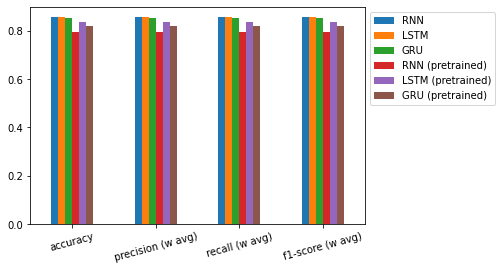

In [58]:
ax = report.plot.bar(rot=15)
ax.legend(loc="upper left", bbox_to_anchor=(1, 1));

Как ни странно, предобученные Embedding'и только ухудшили точности модели.

LSTM выглядит небольшим фаворитом. Но, учитывая непонятное поведение (не готовность реагировать на изменение параметров) всего, я отказываюсь от сравнения моделей и выводов.